Import Libraries

In [57]:
# Data manipulation
import pandas as pd
import numpy as np

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)

# Keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

# Models
import efficientnet.keras as efn 
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

from keras.models import Model, Sequential
from keras.layers import Input, InputLayer, Convolution2D, Activation, MaxPooling2D, BatchNormalization, Flatten, Dense, Conv2D, Dropout, Lambda, GlobalAveragePooling2D
from keras.utils import to_categorical

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from IPython.display import display, Image

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

from sklearn import tree

import cv2
from tqdm import tqdm
import os, re, csv

Checking TensorFlow version and GPU Compatability

In [2]:
print("TF version:", tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

TF version: 2.4.1
Num GPUs: 1


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 1. Data Exploration

Import labels of training images

In [4]:
labels = pd.read_csv("labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Checking for null rows

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


Total number of unique dog breeds

In [6]:
# List of unique breeds
breeds_list = sorted(list(set(labels['breed'])))

unique_breeds = len(breeds_list)
print("Unique breeds:", unique_breeds)

Unique breeds: 120


In [7]:
# delete breeds = list(labels.breed.values)

Checking sample submission file 

Submission requires us to fill the probability values of breeds for each image

In [8]:
sample = pd.read_csv('sample_submission.csv')

In [9]:
sample

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10353,fff1ec9e6e413275984966f745a313b0,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10354,fff74b59b758bbbf13a5793182a9bbe4,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10355,fff7d50d848e8014ac1e9172dc6762a3,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


#### 2. Problem solutions

2 ways we will be doing this:

Part 1. Input > Data Pre-processing > Feature Extraction > Classifier > Predictions

Part 2. Input > Data Pre-processing > Neural Network > Predictions

The difference is in 2, Feature Extraction + Classification will be done by the Neural Network itself, while 1 will be more "manual"

#### Part 1 

##### a) Data Pre-processing

We will set the input shape as size of 224x224, with 3 channels for RGB

In [10]:
# 224x224, RGB = 3 channels
input_shape = (224, 224, 3)

Here we will do a count of images for each unique breeds

In [11]:
breeds_arr = dict(zip(breeds_list, range(unique_breeds)))

In [12]:
breeds_arr

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

First we will convert the training+test images to arrays for input to the feature extractor

In [13]:
# Convert training images to array

# The function will go through the directory that contains the images, and will start to convert each image to a matrix of size 224x224x3, and appends it to the array

def images_to_array(data_dir, labels, img_size=(224,224,3)):

    # Get file name of training images and their respective breeds
    image_id = labels['id']
    image_labels = labels['breed']
    
    # Total number of training images
    data_size = len(image_id)
    
    # Create X and y array templates for training data/labels, fill with 0 first
    X = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
    y = np.zeros([data_size,1], dtype=np.uint8)
    
    # Loops through the entire training data images
    for i in tqdm(range(data_size)):
        image_name = image_id[i]
        
        # We get each file name for the individual images
        img_dir = os.path.join(data_dir, image_name+'.jpg') # Append .jpg
        
        # load_img converts the image to pixels to be stored in the array 
        img_pixels = load_img(img_dir, target_size=img_size)
        
        # Append 224x224x3 matrix to X array
        X[i] = img_pixels
        
        # If image breed matches the label, = 1
        image_breed = image_labels[i]
        y[i] = breeds_arr[image_breed]
    
    # One-hot encoder, converting the labels into arrays
    y = to_categorical(y)
    
    return X, y

In [14]:
# Convert test images to array
# Difference is this function does not have image labels ie. y variable

def images_to_array2(data_dir, labels, img_size = (224,224,3)):
    
    # Get file name of test images
    image_id = labels['id']
    
    # Total number of test images 
    data_size = len(image_id)
    
    # Create array of size 224x224x3 for test data
    X = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    # Loop through the entire test data images
    for i in tqdm(range(data_size)):
        image_name = image_id[i]
        
        # We get each file name for the individual images
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        
        # load_img converts the image to pixels to be stored in the array 
        img_pixels = tf.keras.preprocessing.image.load_img(img_dir, target_size=img_size)
        
        # Append 224x224x3 matrix to X array
        X[i] = img_pixels
        
    return X

##### b) Training and Test data in array

In [15]:
# Training data

X, y = images_to_array('train/', labels, input_shape)

100%|███████████████████████████████████████████████████████████████████████████| 10222/10222 [00:32<00:00, 317.09it/s]


In the X array (training image data), each image will be converted into a matrix of size 224x224x3 (tensor), to visualize, refer to the image below

The X array will have a total of 10222 tensor, each for an image

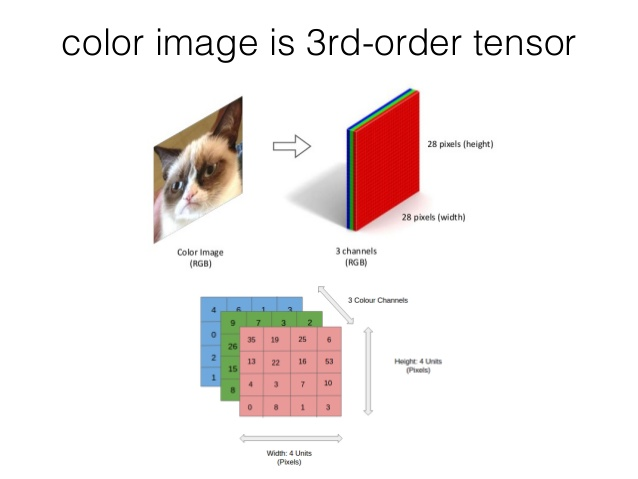

Reference: https://image.slidesharecdn.com/tensordecomposition-170301235239/95/a-brief-survey-of-tensors-5-638.jpg

In [16]:
print('Training Data Size: ', X.shape)

Training Data Size:  (10222, 224, 224, 3)


In [17]:
# Size of first tensor of image

X[0].shape

(224, 224, 3)

In the y array (training image labels), each unique breed will represent a column, where 1=the breed of that image id

10222 rows, 120 columns

In [18]:
print('Training Label Size: ', y.shape)

Training Label Size:  (10222, 120)


In [19]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [20]:
# Test data

test_data = images_to_array2('test/', sample, input_shape)

100%|███████████████████████████████████████████████████████████████████████████| 10357/10357 [00:32<00:00, 313.97it/s]


In [21]:
print('Test Data Size: ', test_data.shape)

Test Data Size:  (10357, 224, 224, 3)


##### c) Feature Extraction

We will be using pre-trained models to extract features from the image data

In [22]:
# Feature Extraction function

def get_features(model_name, data_preprocessor, input_size, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    inputs = Input(input_size)
    
    preprocessor = Lambda(data_preprocessor)(inputs)
    
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    
    avg = GlobalAveragePooling2D()(base_model)
    
    feature_extractor = Model(inputs = inputs, outputs = avg)

    feature_maps = feature_extractor.predict(data, batch_size=64, verbose=1)
    print('Feature shape: ', feature_maps.shape)
    
    return feature_maps

##### Using InceptionV3

Training features

In [23]:
# Extracting training features

inception_features_train = get_features(InceptionV3, preprocess_input, input_shape, X)
#efn_features_train = get_features(efn, preprocess_input, input_shape, X)

160/160 [==============================] - 46s 184ms/step
Feature shape:  (10222, 2048)


Test features

In [24]:
# Extracting test features

inception_features_test = get_features(InceptionV3, preprocess_input, input_shape, test_data)

162/162 [==============================] - 32s 193ms/step
Feature shape:  (10357, 2048)


Split to train / validation set

In [25]:
X_train, X_val, y_train, y_val = train_test_split(inception_features_train, y, shuffle=True)

In [26]:
y.shape

(10222, 120)

##### d) Feeding extracted features to classifier

##### 1. Using Random Forest Classifier

In [28]:
# Initialize 100 trees to be generated
clf = RandomForestClassifier(n_estimators=100, verbose=2)

Fitting

In [29]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  8.9min finished


RandomForestClassifier(verbose=2)

Plotting and Exporting Trees

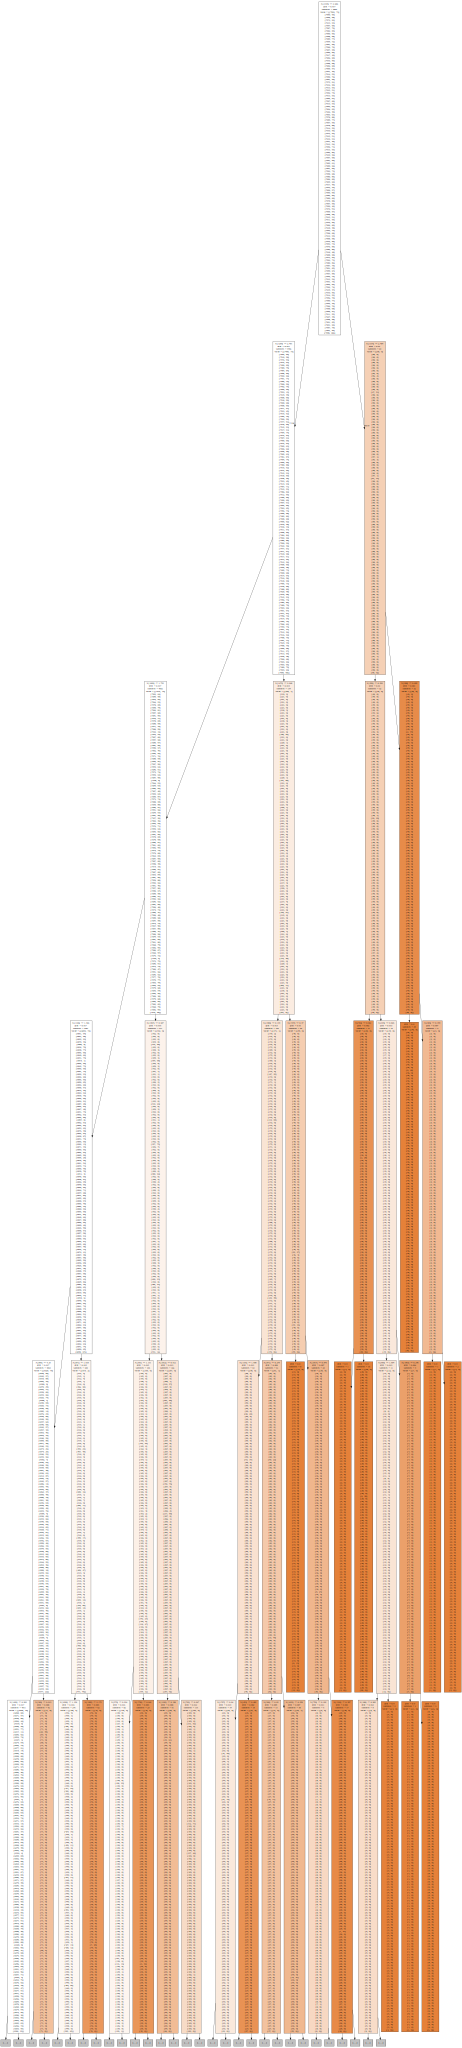

In [61]:
import graphviz
from sklearn import tree

dot = tree.export_graphviz(clf.estimators_[0], 
                           out_file=None, 
                           class_names=breeds_list, 
                           filled=True,
                           max_depth=5)

graph = graphviz.Source(dot, format="png") 
graph

In [63]:
graph.format = "png"
graph.render("tree0_depth5")

'tree0_depth5.png'

Prediction on validation set

In [33]:
f2_pred_val = clf.predict(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


Evaluation

In [42]:
print("Accuracy:", accuracy_score(y_val, f2_pred_val))

Accuracy: 0.3853677621283255


Prediction on test set

In [58]:
f2_pred = clf.predict(inception_features_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   10.2s finished


##### 2. Using a simple neural network as a classifier

Building the model

In [36]:

# 2048
inputs = keras.Input(shape=inception_features_train.shape[1:])

x = Dense(64, activation='relu')(inputs)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

outputs = Dense(unique_breeds, activation='softmax')(x) # Classification layer

f1 = keras.Model(inputs, outputs, name='DNN')

f1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

f1.summary()

Model: "DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_189 (Bat (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 120)               7800      
Total params: 139,192
Trainable params: 139,064
Non-trainable params: 128
_________________________________________________________________


Setting callbacks

In [37]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('models/', 'inceptionfeatures_best_val_loss2.h5'),
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# If the validation loss doesn't improve, stop training
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

Training the model

In [38]:
bs = 64
epoch = 10

In [39]:
f1_h = f1.fit(X_train, y_train, 
              batch_size=bs, 
              epochs=epoch, 
              validation_split=0.2, 
              callbacks=[model_checkpoint, earlystopping])

Epoch 1/10
96/96 [==============================] - 1s 7ms/step - loss: 4.3654 - accuracy: 0.1203 - val_loss: 2.8297 - val_accuracy: 0.6219
Epoch 2/10
96/96 [==============================] - 1s 5ms/step - loss: 3.0495 - accuracy: 0.4698 - val_loss: 2.0382 - val_accuracy: 0.7171
Epoch 3/10
96/96 [==============================] - 0s 5ms/step - loss: 2.4023 - accuracy: 0.5831 - val_loss: 1.6323 - val_accuracy: 0.7549
Epoch 4/10
96/96 [==============================] - 1s 5ms/step - loss: 1.9494 - accuracy: 0.6289 - val_loss: 1.2815 - val_accuracy: 0.7653
Epoch 5/10
96/96 [==============================] - 0s 5ms/step - loss: 1.6866 - accuracy: 0.6515 - val_loss: 1.1317 - val_accuracy: 0.7692
Epoch 6/10
96/96 [==============================] - 0s 5ms/step - loss: 1.4618 - accuracy: 0.6886 - val_loss: 1.0366 - val_accuracy: 0.7751
Epoch 7/10
96/96 [==============================] - 0s 4ms/step - loss: 1.2873 - accuracy: 0.7100 - val_loss: 0.9780 - val_accuracy: 0.7686
Epoch 8/10
96/96 [==

Model Evaluation

In [40]:
score1 = f1.evaluate(x=X_val, y=y_val, verbose=1)

print(f' Loss: {score1[0]}\n Accuracy: {score1[1]}')

80/80 [==============================] - 0s 2ms/step - loss: 0.8401 - accuracy: 0.7739
 Loss: 0.8400923609733582
 Accuracy: 0.7738654017448425


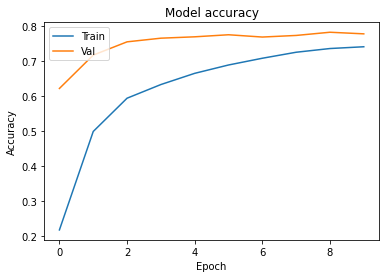

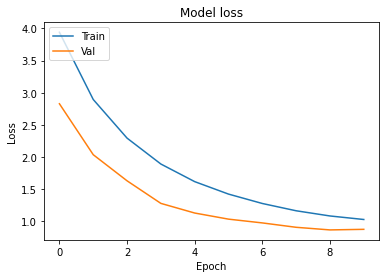

In [41]:
plt.plot(f1_h.history['accuracy'])
plt.plot(f1_h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(f1_h.history['loss'])
plt.plot(f1_h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Prediction on test data

In [42]:
f1_pred = f1.predict(inception_features_test, batch_size=bs)

##### e) Predictions 

Here we compare the results of using different classifiers 

##### 1. Random Forest Classifier

In [64]:
print("Accuracy:", accuracy_score(y_val, f2_pred_val))

Accuracy: 0.3853677621283255


##### 2. Simple Neural Network Classifier

In [69]:
print('Loss:', score1[0])
print('Accuracy:', score1[1])     

Loss: 0.7382540106773376
Accuracy: 0.798904538154602


In this case we will take the predictions using the simple neural network classifier

##### f) Output to submission file

In [70]:
f1_df = sample

for x in breeds_list:
    f1_df[x] = f1_pred[:, breeds_arr[x]]

f1_df.to_csv('submission_feature_extraction.csv', index=None)

#### Part 2 

##### a) Data Pre-processing

In [10]:
labels2 = labels

In [11]:
labels2['id'] = labels2['id'] + '.jpg'

Here we split our labels data into training and validation set

In [12]:
train, val = train_test_split(labels2, test_size=0.2, shuffle=True)

In [13]:
print("Train shape:", train.shape)
print("Validation shape:", val.shape)

Train shape: (8177, 2)
Validation shape: (2045, 2)


Image data augmentation


We "create" more training data from existing data by doing image manipulation (Rotate/Zoom/Scaling/Contrast) (Get more variants of image for neural network to learn)

This will help improve the performance of the neural network

For more info: https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5

By using keras image data generator it will feed each image into the network so we do not need to do manual feature extraction

In [14]:
# Datagen

train_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255, # Scale/Normalize pixel value from range [0,255] to [0,1], RGB coeff in 0-255 too high for model to process
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

val_gen = ImageDataGenerator(
    rescale=1./255)

test_gen = ImageDataGenerator(
            rescale=1./255)

Retrieve our training/val/test sets

In [15]:
# Training / Validation / Test set

bs = 64

training_set = train_gen.flow_from_dataframe(
    dataframe=train,
    directory='train/',
    x_col="id",
    y_col="breed",
    target_size=(224, 224), # Has to match input_shape
    class_mode="categorical",
    batch_size=bs,
    seed=42,
    shuffle=True
)

validation_set = val_gen.flow_from_dataframe(
    dataframe=val,
    directory='train/',
    x_col="id",
    y_col="breed",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=bs,
    seed=42,
    shuffle=True
)

test_set = test_gen.flow_from_directory(
    '',
    target_size = (224, 224),
    batch_size = bs,
    classes=['test'],
    seed=42,
    shuffle=False
)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.
Found 10357 images belonging to 1 classes.


In [16]:
step_size_train = training_set.n // bs
step_size_val = validation_set.n // bs

##### b) Neural Networks

##### 1. CNN (Convolutional Neural Network)

Building a CNN Model from scratch

In [76]:
# Create a sequential model
inputs = keras.Input(shape=input_shape)

x = Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[224, 224, 3])(inputs)
x = MaxPooling2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2)(x)

x = Flatten()(x)
x = Dense(units=64, activation='relu')(x)

outputs = Dense(unique_breeds, activation='softmax')(x) # Classification layer

cnn = Model(inputs, outputs, name='CNN')

cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

View summary of the CNN model

In [77]:
cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 26, 26, 64)        0       

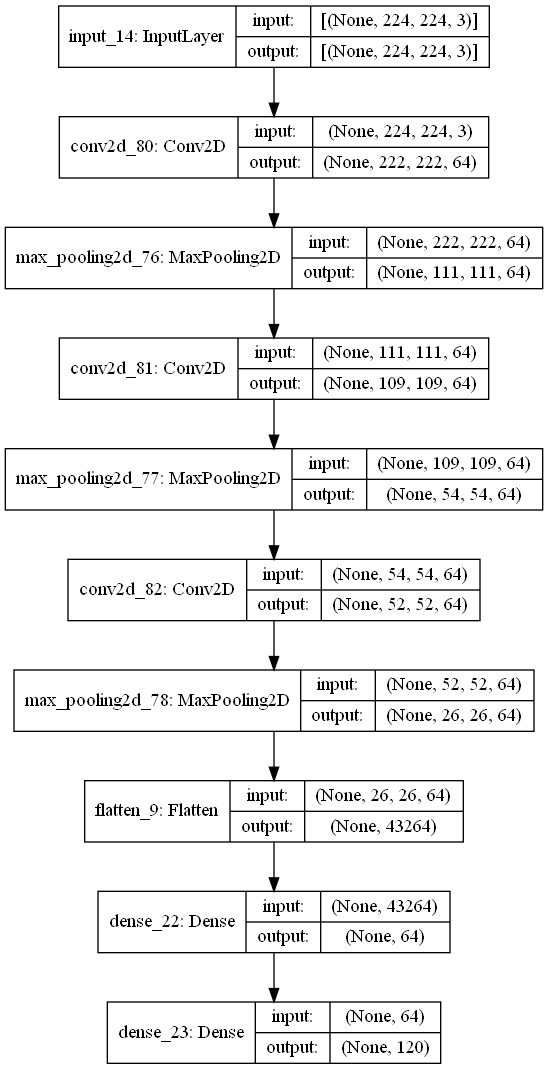

In [78]:
model_plot = tf.keras.utils.plot_model(cnn, show_shapes=True)
display(model_plot)

Checkpoints

In [74]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('models/', 'cnn_best_val_loss2.h5'),
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# If the validation loss doesn't improve, stop training
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)

# If the validation loss doesn't improve, reduce the learning rate to 0.2 times it's previous value

# New LR = Old LR * factor
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3)

Training the CNN model

In [75]:
# Samples // batch size = # of batches
# 1 epoch trains # of batches
# Weights updated after each batch 

epochs = 10

history = cnn.fit(training_set,
          epochs=epochs,
          steps_per_epoch=step_size_train,
          validation_data=validation_set,
          validation_steps=step_size_val,
          callbacks=[model_checkpoint, earlystopping, reduce_lr], shuffle=True, verbose=1)

Epoch 1/10
127/127 [==============================] - 95s 740ms/step - loss: 4.7898 - accuracy: 0.0083 - val_loss: 4.7865 - val_accuracy: 0.0101
Epoch 2/10
127/127 [==============================] - 93s 735ms/step - loss: 4.7846 - accuracy: 0.0133 - val_loss: 4.7853 - val_accuracy: 0.0096
Epoch 3/10
127/127 [==============================] - 93s 732ms/step - loss: 4.7807 - accuracy: 0.0109 - val_loss: 4.7848 - val_accuracy: 0.0101
Epoch 4/10
127/127 [==============================] - 94s 738ms/step - loss: 4.7801 - accuracy: 0.0100 - val_loss: 4.7883 - val_accuracy: 0.0101
Epoch 5/10
127/127 [==============================] - 95s 744ms/step - loss: 4.7788 - accuracy: 0.0105 - val_loss: 4.7834 - val_accuracy: 0.0136
Epoch 6/10
127/127 [==============================] - 95s 745ms/step - loss: 4.7777 - accuracy: 0.0135 - val_loss: 4.7844 - val_accuracy: 0.0096
Epoch 7/10
127/127 [==============================] - 96s 756ms/step - loss: 4.7767 - accuracy: 0.0124 - val_loss: 4.7845 - val_ac

Save final CNN model

In [91]:
cnn.save('models/final_cnn.h5')

Model Evaluation

In [93]:
# Loss - Accuracy 

score3 = cnn.evaluate(validation_set, steps=step_size_val, verbose=1)

31/31 [==============================] - 6s 181ms/step - loss: 4.2956 - accuracy: 0.0499


In [94]:
print('Loss:', score3[0])
print('Accuracy:', score3[1])  

Loss: 4.2955522537231445
Accuracy: 0.04989919438958168


Accuracy + Loss plot

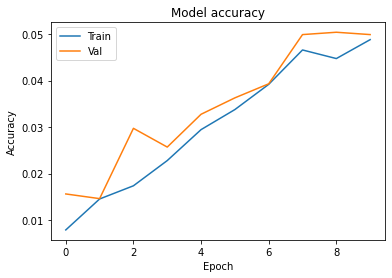

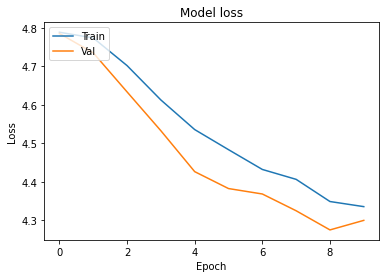

In [95]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Prediction on test set

In [76]:
cnn_y_pred = cnn.predict(test_set, verbose=1)

162/162 [==============================] - 28s 174ms/step


##### 2. EfficientNet

Using pre-trained EfficientNet model in keras (Transfer Learning)

In [96]:
# Set include_top=False, as we will be using our own classification layer
# Using imagenet weights

eff = efn.EfficientNetB1(weights='imagenet', input_shape=(224,224,3), include_top=False)

Building classification layer on top

In [107]:
inputs = keras.Input(shape=(224,224,3))

x = eff(inputs)

x = GlobalAveragePooling2D()(x)

x = Dense(units=64,activation='relu')(x)

#x = Dropout(0.5)(x)

outputs = Dense(unique_breeds, activation='softmax')(x) # Sum of Prob = 1 

effnet = Model(inputs, outputs, name='EfficientNet')

effnet.layers[1].trainable=False # Freeze EfficientNet 

effnet.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) # Multi-class, Labels in one-hot, use categorical_crossentropy

View Summary of the EfficientNet model

In [108]:
effnet.summary()

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b1 (Functional) (None, 7, 7, 1280)        6575232   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                81984     
_________________________________________________________________
dense_11 (Dense)             (None, 120)               7800      
Total params: 6,665,016
Trainable params: 89,784
Non-trainable params: 6,575,232
_________________________________________________________________


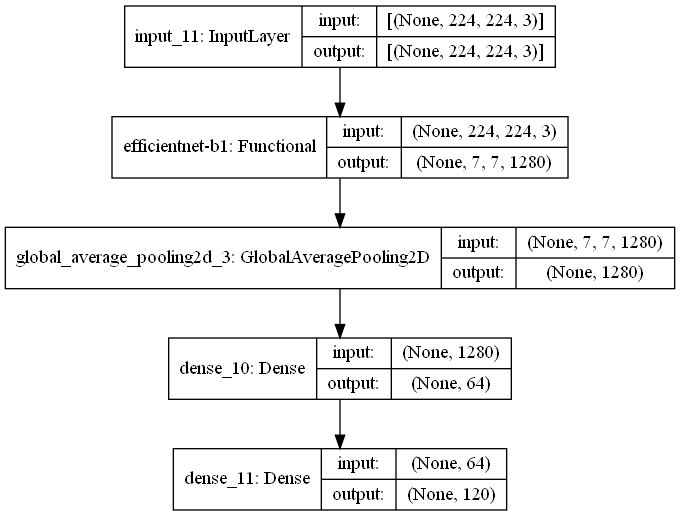

In [109]:
model_plot2 = tf.keras.utils.plot_model(effnet, show_shapes=True)
display(model_plot2)

Checkpoints

In [110]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('models/', 'efnnet_best_val_loss2.h5'),
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# If the validation loss doesn't improve, stop training
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)

# If the validation loss doesn't improve, reduce the learning rate to 0.2 times it's previous value

# New LR = Old LR * factor
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3)

Training the model

In [111]:
epochs = 10

In [112]:
history2 = effnet.fit(training_set,
          epochs=epochs,
          steps_per_epoch=step_size_train,
          validation_data=validation_set,
          validation_steps=step_size_val,
          callbacks=[model_checkpoint, earlystopping], verbose=1)

Epoch 1/10
127/127 [==============================] - 104s 766ms/step - loss: 4.3247 - accuracy: 0.1077 - val_loss: 2.1151 - val_accuracy: 0.5670
Epoch 2/10
127/127 [==============================] - 94s 742ms/step - loss: 2.1792 - accuracy: 0.4681 - val_loss: 1.3026 - val_accuracy: 0.6678
Epoch 3/10
127/127 [==============================] - 95s 745ms/step - loss: 1.6306 - accuracy: 0.5632 - val_loss: 1.0726 - val_accuracy: 0.7112
Epoch 4/10
127/127 [==============================] - 96s 755ms/step - loss: 1.4754 - accuracy: 0.5957 - val_loss: 0.9950 - val_accuracy: 0.7193
Epoch 5/10
127/127 [==============================] - 95s 747ms/step - loss: 1.4136 - accuracy: 0.6111 - val_loss: 0.9360 - val_accuracy: 0.7258
Epoch 6/10
127/127 [==============================] - 97s 764ms/step - loss: 1.3085 - accuracy: 0.6271 - val_loss: 0.9033 - val_accuracy: 0.7334
Epoch 7/10
127/127 [==============================] - 95s 748ms/step - loss: 1.2294 - accuracy: 0.6632 - val_loss: 0.8762 - val_a

Save final model

In [113]:
effnet.save('models/final_effnet.h5')

In [99]:
# Load model
# effnet = keras.models.load_model('models/final_effnet.h5')

Model Evaluation

In [100]:
score4 = effnet.evaluate(validation_set, steps=step_size_val, verbose=1)

31/31 [==============================] - 14s 188ms/step - loss: 0.6541 - accuracy: 0.7979


In [115]:
print('Loss:', score4[0])
print('Accuracy:', score4[1])  

Loss: 0.850140392780304
Accuracy: 0.7525201439857483


Accuracy + Loss Plot

In [101]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

NameError: name 'history2' is not defined

Prediction on test set

In [102]:
efnnet_y_pred = effnet.predict(test_set, verbose=1)

162/162 [==============================] - 39s 231ms/step


##### c) Models Evaluation

In [122]:
print("CNN:\n")
print(f' Loss: {score3[0]}\n Accuracy: {score3[1]}')
print("\n")
print("EfficientNet:\n")
print(f' Loss: {score4[0]}\n Accuracy: {score4[1]}')

CNN:

 Loss: 4.2955522537231445
 Accuracy: 0.04989919438958168


EfficientNet:

 Loss: 0.850140392780304
 Accuracy: 0.7525201439857483


-- 

##### d) Submission

Since EfficientNet has produced a better validation accuracy, we will use it for submission

In [103]:
sample2 = pd.read_csv('sample_submission.csv')

Get list of filenames

In [104]:
files = test_set.filenames
ids = []

for name in files:
    m = re.sub('test', '', name)
    m = re.sub('.jpg', '', m)
    m = m.replace("\\", "")

    ids.append(m)

In [105]:
ids

['000621fb3cbb32d8935728e48679680e',
 '00102ee9d8eb90812350685311fe5890',
 '0012a730dfa437f5f3613fb75efcd4ce',
 '001510bc8570bbeee98c8d80c8a95ec1',
 '001a5f3114548acdefa3d4da05474c2e',
 '00225dcd3e4d2410dd53239f95c0352f',
 '002c2a3117c2193b4d26400ce431eebd',
 '002c58d413a521ae8d1a5daeb35fc803',
 '002f80396f1e3db687c5932d7978b196',
 '0036c6bcec6031be9e62a257b1c3c442',
 '0041940322116ae58c38130f5a6f71f9',
 '0042d6bf3e5f3700865886db32689436',
 '004476c96f575879af4af471af65cae8',
 '00485d47de966a9437ad3b33ac193b6f',
 '00496f65de6cc319145ce97bd6e90360',
 '004bf14426d1a830d459a9e0c0721309',
 '004c3721eb88358f462cdcec6b2380b7',
 '00559f56aab7e0a7749220f6aed65162',
 '005b281f1a4d6f29d527c9585e9bd33c',
 '005b6c6c76fefd6b458ef6fb6e54da6e',
 '006870b49353779b25eeb91fed43c31a',
 '0068f3a21b159ece126a28580cdad7a0',
 '0069b1cc4546fc98f84f981bf9a0696a',
 '0077bc3c63486ff09d3774d956af8f76',
 '00780e5d2bf4f7e4b5f96d08ddde669a',
 '007ed71136966728f5c0936e23c8286b',
 '0081831ceb49cd64212c32b884036b82',
 

Map each prediction value to its respective class for each image/file

In [106]:
sample2['id'] = ids
sample2.iloc[:,1:] = efnnet_y_pred

Output to csv

In [107]:
submission = sample2.set_index('id')
submission.to_csv('submission.csv')

In [108]:
submission.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,
000621fb3cbb32d8935728e48679680e,5.411604e-06,0.000078,1.819213e-05,1.035349e-07,3.957649e-07,0.000019,0.000005,8.592656e-06,7.872302e-07,0.000006,...,0.000039,0.000022,4.288323e-06,0.000016,0.000003,0.000023,3.743455e-07,0.000039,0.000011,0.000018
00102ee9d8eb90812350685311fe5890,3.232107e-05,0.000006,8.406681e-07,4.072479e-06,4.123097e-05,0.000004,0.000011,7.172816e-05,2.645348e-05,0.000112,...,0.000039,0.000073,6.823838e-07,0.000003,0.000548,0.000002,2.082450e-03,0.000020,0.000021,0.000005
0012a730dfa437f5f3613fb75efcd4ce,8.806769e-08,0.012468,2.233948e-05,2.087534e-03,1.857318e-05,0.000216,0.000001,1.667638e-08,8.012716e-06,0.000006,...,0.000001,0.000001,1.714005e-04,0.000031,0.003480,0.003946,1.011144e-05,0.000792,0.000095,0.000034
001510bc8570bbeee98c8d80c8a95ec1,1.739650e-04,0.000764,1.622506e-04,5.824235e-05,9.853229e-04,0.010381,0.006417,9.609216e-02,4.723147e-04,0.018869,...,0.000190,0.064818,2.954752e-03,0.001702,0.002957,0.000453,3.003677e-05,0.048283,0.000044,0.052864
001a5f3114548acdefa3d4da05474c2e,2.233717e-03,0.003338,1.247783e-05,5.874366e-06,1.368552e-07,0.000001,0.000435,1.156208e-07,2.358156e-07,0.000001,...,0.000082,0.000013,3.949719e-06,0.000001,0.000003,0.000011,2.182862e-04,0.000015,0.000013,0.000593


#### 3. Visualizing image features on Tensorboard Projector

Will be using features extracted from Part 1

Involves Dimensionality Reduction (PCA) to display the images on a 3D plane in the projector

In [25]:
# Start up tensorboard
%load_ext tensorboard

In [26]:
len(inception_features_test)

10357

1. Create feature vectors + metadata (labels)

In [27]:
# Export to tsv file for embedding projector

# Features
np.savetxt("inception_features_test.tsv", inception_features_test, delimiter="\t")

Labels for test data

In [43]:
meta_arr = f1_pred

# Take the highest value/"predicted" breed for each test img/file
meta_arr = (meta_arr == meta_arr.max(axis=1, keepdims=1)).astype(int)

In [44]:
meta_arr[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [45]:
# Convert to DF - Easier to read
meta_df = sample

for x in breeds_list:
    meta_df[x] = meta_arr[:, breeds_arr[x]]

In [46]:
meta_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00102ee9d8eb90812350685311fe5890,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0012a730dfa437f5f3613fb75efcd4ce,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,001510bc8570bbeee98c8d80c8a95ec1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,001a5f3114548acdefa3d4da05474c2e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10353,fff1ec9e6e413275984966f745a313b0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10354,fff74b59b758bbbf13a5793182a9bbe4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10355,fff7d50d848e8014ac1e9172dc6762a3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# Reversing OHE array

# Label each img/file to its predicted breed
def reverse_OHE(row):
    for c in meta_df.columns:
        if row[c]==1:
            return c

In [48]:
reverse_meta_df = pd.DataFrame(meta_df.apply(reverse_OHE, axis=1))

In [49]:
# Joining img id 
reverse_meta_df = reverse_meta_df.join(meta_df['id'])

In [50]:
# Rename headers
reverse_meta_df.columns = ['breed', 'id']

In [51]:
reverse_meta_df

,breed,id
0,japanese_spaniel,000621fb3cbb32d8935728e48679680e
1,samoyed,00102ee9d8eb90812350685311fe5890
2,english_setter,0012a730dfa437f5f3613fb75efcd4ce
3,whippet,001510bc8570bbeee98c8d80c8a95ec1
4,tibetan_terrier,001a5f3114548acdefa3d4da05474c2e
...,...,...
10352,standard_poodle,ffeda8623d4eee33c6d1156a2ecbfcf8
10353,weimaraner,fff1ec9e6e413275984966f745a313b0
10354,dhole,fff74b59b758bbbf13a5793182a9bbe4
10355,lhasa,fff7d50d848e8014ac1e9172dc6762a3


In [52]:
# Export to tsv file 

metadata = reverse_meta_df[['id', 'breed']].to_csv('metadata.tsv', sep='\t', index=False)

2. Create sprite image (Collage) to be displayed on the projector

In [53]:
! magick montage test/*.jpg -tile 103x103 -geometry 50x50! sprite.jpg
print("Done")

Done


3. Create config file

In [54]:
# projector_config.pbtxt should look like this

# embeddings {
#   tensor_path: "inception_features_test.tsv"
#   metadata_path: "metadata.tsv"
#   sprite {
#     image_path: "sprite.jpg"
#     single_image_dim: 50
#     single_image_dim: 50
#   }
# }

# with open('projector_config.pbtxt', 'w') as file:
#     file.write('embeddings { tensor_path: "inception_features_test.tsv" metadata_path: "metadata.tsv" sprite { image_path: "sprite.jpg" single_image_dim: 50 single_image_dim: 50 } }')


Run tensorboard locally

In [55]:
! tensorboard --logdir .

^C


Open: http://localhost:6006/#projector

References

[1] https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/

[2] https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624

[3] https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.&text=The%20rectified%20linear%20activation%20function%20overcomes%20the%20vanishing%20gradient%20problem,learn%20faster%20and%20perform%20better

[4] https://lisaong.github.io/mldds-courseware/01_GettingStarted/numpy-tensor-slicing.slides.html

[5] https://medium.com/@kumon/visualizing-image-feature-vectors-through-tensorboard-b850ce1be7f1

[6] https://cloud.google.com/tpu/docs/inception-v3-advanced
